# ОСНОВНАЯ ИНФОРМАЦИЯ О ТЕТРАДИ

В данном ipynb файле представлены следующие коды с пояснительными комментариями внутри:              
1 - функция однофакторного дисперсионного анализа произвольного количества групп                     
1.1 - доверительные интервалы (шаблон)              
1.2 - функция с результатом проблемы множественного сравнения по F-критерию (визуализация + поправка Бонферрони)

2 - функция двухфакторного дисперсионного анализа произвольного количества групп                       
2.1 - таблица со средними значениями между факторами                        
2.2 - доверительные интервалы (шаблон)

3 - анализ данных по генной терапии (один фактор), название датафрейма - gene                 
3.1 - анализ данных по атеросклерозу (два фактора), название датафрейма - athero                  
3.2 - анализ данных по гормону у птиц (два фактора), название датафрейма - birds


В конце приведен анализ данных датафреймов, взятых из курса "Основы статистики" шагов 2.4 "Однофакторный дисперсионный анализ" и 2.6 "Многофакторный дисперсионный анализ", расположенного на платформе Stepik. Пункт 1.2 настоящей тетради отсылает к шагу 2.5 "Множественное сравнение в ANOVA" вышепредставленного курса.

Ссылка на курс -- https://stepik.org/course/76/syllabus



P.S. В анализе датафреймов уникальные значения групп факторов отображенны неявно, это связанно с тем, что присутствовало опасение исказить исходные данные в связи с отсутствием однозначной трактовки каждого из значений.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # library for vizualization
import scipy.stats as stats

#plt.style.use('dark_background')
sns.set(rc={'figure.figsize':(7, 5)})

# 1
Ниже представленна функция, выполняющяя однофакторный анализ для неограниченного количества групп по общему массиву данных df
и таблице-своднику этих групп t, где Therapy - независимая переменная, а expr - зависимая переменная

In [2]:
# [Дата фрейм, Фактор, Зависимая переменная]
def one_way_anova(df, a:str, dv:str):

    df_bg = df[f'{a}'].nunique() - 1                                  # число степеней свободы between groups
    df_wg = df[f'{a}'].count() - df[f'{a}'].nunique()                 # число степеней свободы within groups
    g_mean = df[f'{dv}'].mean()                                       # среднее значение всех значений всех терапий
    df_dict = {'df_bg': df_bg, 'df_wg': df_wg, 'df_t': df_bg + df_wg} # словарь степеней свобод
    
    ssw, ssb = 0, 0                                                  # показатель Sum of Squares Between и Sum of Squares Within
    for i in df[f'{a}'].unique():                                    # выбор группы фактора 
        m = df[df[f'{a}'] == i][f'{dv}']                             # для повышения читабельности кода
        ssw += sum([(k-m.mean())**2 for k in m])                     # ssq между группами
        ssb += m.count() * (m.mean() - g_mean)**2                    # ssb внутри групп
    
    ssq_dict = {'ssb': ssb, 'ssw': ssw, 'ssq_t': ssw + ssb}                 # словарь квадратов
    ssq_mean_dict = {'ssq_mean_b': ssb / df_bg, 'ssq_mean_w': ssw / df_wg}  # словарь средних групповых квадрато   
    F = ssq_mean_dict['ssq_mean_b'] / ssq_mean_dict['ssq_mean_w']           #  F значение
    p = 1 - stats.f.cdf(F, df_bg, df_wg)                                    # p-value
    
    result = (pd.DataFrame({'Sum of Squares': ssq_dict.values(), 
                             'Degrees of Freedom': df_dict.values(), 
                             'Mean Square' : list(ssq_mean_dict.values()) + [np.nan],
                             'F ratio': [F] + [np.nan] * 2,
                             'p-value': [p] + [np.nan] * 2}, 
                           index=[f'Sum of Squares Factor ({a})', 'Sum of Squares Within', 'Sum of Squares Total']).
                           round({'Sum of Squares': 2, 'Mean Square': 2, 'F ratio': 2, 'p-value': 4}))
    
    return result

# 1.1
Доверительные интервалы однофакторного дисперсионного анализа (ШАБЛОН)

In [3]:
def one_way_intervals():
    pplot = sns.pointplot(x='Therapy', y='expr', dodge=0.1, capsize=0.1, data=gene)
    plt.title('Зависимость уровня экспрессии гена от вида терапии', fontsize=12)
    plt.xlabel('Виды терапий', fontsize=12)
    plt.ylabel('Экспрессия гена', fontsize=12)
    plt.show()

# 1.2
Ниже приведена проблема сравнения по F-критерю однофакторного дисперсионного анализа среди множества выборок, то есть с увеличением числа попарно сравниваемых выборок шанс получить хотя бы одну стаистически значимую взаимосвязь возрастает

ВНИМАНИЕ! Оптимизировано (3) раза. По-прежнему неудовлетворительно. Слишком долгое время компиляции кода

In [4]:
# создаем нормальное распределение с M = 50 (среднее) и D = 1 (средн. квадр. откл-е)
nd = np.random.normal(50, 1, 1000)  

# [Размер выборки, Кол-во сравниваемых между собой попарно выборок, Поправка Бонферрони: 1 - Да, 0 - Нет]
def select(n, rng, bf = 0):
    
    e = {'Yes': 0} 
    pv = 0.05  # значение p-value
    
    if bf == 1:  # проверка на наличие поправки Бонферрони
        pv = 0.05 / (rng*(rng-1) / 2)
        bf = 'да'
    else:
        bf = 'нет'
        
    
    for _ in range(1000):  # сколько всего раз мы отбираем выборки из ген. совокупности    
        # выбираем rng случайных выборок размером n из ген. совокупности nd
        d = np.array([np.random.choice(nd, n) for _ in range(rng)])

        for i in range(rng):  # алгоритм попарного сравнения выборок, общее количество сравнений равно rng(rng-1)/2
            check = None  # флаг наличия значимой взаимосвязи для прерывания внешнего цикла
            for k in range(i+1, rng):
                df = pd.DataFrame({'a':['A'] * n + ['B'] * n, 'dv': np.concatenate((d[i], d[k]))})
                
                # применение однофакторного дисперсионного анализа с помощью вышепредставленной функции one_way_anova
                # из таблицы выбирается сразу p-value
                t = one_way_anova(df, 'a', 'dv').loc['Sum of Squares Factor (a)']['p-value']  

                if t <= pv :  # если между двумя выборками обнаружилась значимая взаимосвязь, внутренний цикл прерывается
                    e['Yes'] += 1  
                    check = True
                    break
            
            if check:
                break
    
    e['No'] = 1000 - e['Yes']
    
    def addlabels(x,y):  # функция для добавления значений к столбцам
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha = 'center')
        

    plt.bar(list(e.keys()), e.values(), color='g')
    plt.title(f'Результаты попарного сравнения среди {rng} выборок объемом {n}\nВыборки отбирались 1000 раз, наличие поправки Бонферонни: {bf}')
    addlabels(list(e.keys()), list(e.values()))
    plt.show()

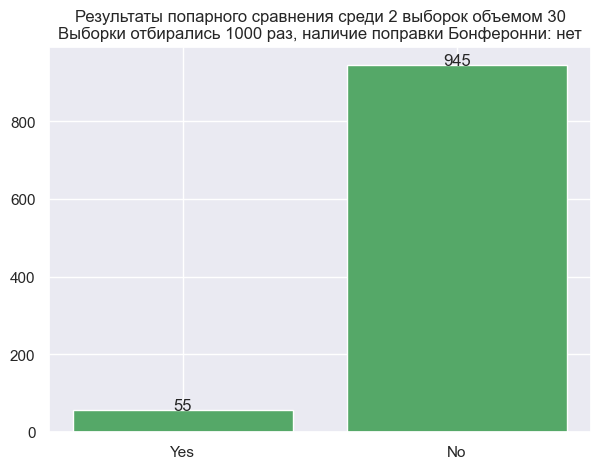

In [5]:
select(30, 2)

# 2.
Двухфакторный дисперсионный анализ

In [6]:
#  [Дата фрейм, Первый фактор, Второй фактор, Зависимая переменная]
def two_way_anova(df, a:str, b:str, dv:str):
    
    # общее среднее
    global_mean = df[f'{dv}'].mean()
    
    # === Подсчет квадратов ===
    # сумма квадратов по фактору a
    ssq_a = sum([len(df[df[f'{a}']==i])*(df[df[f'{a}']==i][f'{dv}'].mean()-global_mean)**2 for i in df[f'{a}'].unique()])
    
    # сумма квадратов по фактору b
    ssq_b = sum([len(df[df[f'{b}']==i])*(df[df[f'{b}']==i][f'{dv}'].mean()-global_mean)**2 for i in df[f'{b}'].unique()])
    
    # общая сумма квадратов
    ssq_t = sum((df[f'{dv}']-global_mean)**2)
    
    # групповая сумма квадратов
    ssq_w = 0
    for k in df[f'{a}'].unique():  # выбор группы внутри фактора a
        for j in df[df[f'{a}']==k][f'{b}'].unique(): # выбор группы фактора b внутри конкретно этой группы фактора a
            ssq_w += sum([(i - df[(df[f'{a}']==k) & (df[f'{b}']==j)][f'{dv}'].mean())**2 
                          for i in df[(df[f'{a}']==k) & (df[f'{b}']==j)][f'{dv}']])
    
    # сумма квадратов обоих факторов    
    ssq_ab = ssq_t - ssq_a - ssq_b - ssq_w
    
    # СЛОВАРЬ квадратов
    ssq_dict = {'ssq_a': ssq_a, 'ssq_b': ssq_b, 'ssq_ab': ssq_ab, 'ssq_w' : ssq_w, 'ssq_t': ssq_t}
    
    
    # === Подсчет степеней свободы ===
    # степени свободы фактора a
    df_a = len(df[f'{a}'].unique()) - 1
    
    # степени свободы фактора b
    df_b = len(df[f'{b}'].unique()) - 1
    
    # степени свободы среди групп
    df_w = 0
    for k in df[f'{a}'].unique():  # выбор группы внутри фактора a
        for j in df[df[f'{a}']==k][f'{b}'].unique():  # выбор группы фактора b внутри конкретно этой группы фактора a
            df_w += df[(df[f'{a}'] == k) & (df[f'{b}'] == j)][f'{dv}'].count() - 1
    
    # степени свободы обоих факторов
    df_ab = df_a * df_b 
    
    # общее количество степеней свобод
    df_t = df_a + df_b + df_w + df_ab
    
    # СЛОВАРЬ степеней свобод
    df_dict = {'df_a':df_a, 'df_b':df_b, 'df_ab':df_ab, 'df_w':df_w, 'df_t':df_t}
    
    
    # === Подсчет средней суммы квадратов === 
    # СЛОВАРЬ средней суммы квадратов
    ssq_mean_dict = {'ssq_a_mean': ssq_a / df_a, 'ssq_b_mean': ssq_b / df_b,
                     'ssq_ab_mean': ssq_ab / df_ab, 'ssq_w_mean': ssq_w / df_w}
    
    
    # === Подсчет F-значений ===
    F_a = ssq_mean_dict['ssq_a_mean'] / ssq_mean_dict['ssq_w_mean']
    F_b = ssq_mean_dict['ssq_b_mean'] / ssq_mean_dict['ssq_w_mean']
    F_ab = ssq_mean_dict['ssq_ab_mean'] / ssq_mean_dict['ssq_w_mean']
    
    # СЛОВАРЬ F-значений
    F_dict = {'F_a':F_a, 'F_b':F_b, 'F_ab':F_ab}
    
    
    # === Подсчет p-value ===
    # СЛОВАРЬ p-value
    p_dict = {'p_a': 1 - stats.f.cdf(F_a, df_a, df_w),   
              'p_b': 1 - stats.f.cdf(F_b, df_b, df_w),
              'p_ab': 1 - stats.f.cdf(F_ab, df_ab, df_w)}
    
    result = pd.DataFrame({'Sum of Squares':ssq_dict.values(),
                           'Degrees of Freedom':df_dict.values(), 
                           'Mean Square': list(ssq_mean_dict.values()) + [np.nan], 
                           'F ratio': list(F_dict.values()) + [np.nan]*2, 
                           'p-value': list(p_dict.values()) + [np.nan]*2}, 
                            index = [f'Sum of Squares 1st Factor ({a})', 
                            f'Sum of Squares 2nd Factor ({b})', 
                            'Sum of Squares Both Factors', 
                            'Sum of Squares Within (Error)', 
                            'Sum of Squares Total']).round({'Sum of Squares':2, 'Mean Square':2, 'F ratio':2, 'p-value':4})
    
    return result

# 2.1
Таблица со средними значениями по группам. 
* Нижепредставленный код написан с помещением передаваемого фактора 'a' в зону индексации дата фрейма, возможно стоило осуществить его перенос в отдельный столбец

In [7]:
#  [Дата фрейм, Первый фактор, Второй фактор, Зависимая переменная]
def mean_table(df, a:str, b:str, dv:str):
    
    # создание столбцов и индексов
    t = pd.DataFrame(index = [np.append(df[f'{a}'].unique(), 'Average')], 
                     columns = [np.append(df[f'{b}'].unique(), 'Average')])
    
    # среднеe значениe факторов b внутри каждого отдельного фактора a
    for i in df[f'{a}'].unique():  # выбор группы фактора a
        for j in df[df[f'{a}'] == i][f'{b}'].unique():  # среди группы i фактора a выбор принадлежащей ей группы j фактора b
            t.at[i, j] = df[(df[f'{a}'] == i) & (df[f'{b}'] == j)][f'{dv}'].mean()  # присвоение по индексу и столбцу
    
    # среднее значение между факторами a по факторам b
    for i in df[f'{b}'].unique():
        t.at['Average', i] = float(t.loc[df[f'{a}'].unique()][i].mean())
        
    # среднее значение факторов b для каждого фактора a
    for i in df[f'{a}'].unique():
        s = 0
        for j in df[f'{b}'].unique():
            s += t.loc[i, df[f'{b}'].unique()][j].squeeze()  # squeeze() "извлекает" данные из одиночной ячейки df, 
            t.at[i, 'Average'] = s / len(df[f'{b}'].unique())    # преобразуя их в series
            
    # общее среднее всех элементов
    t.at['Average', 'Average'] = df[f'{dv}'].mean()
    t = t.astype(float).round(2)
    
    return t

# 2.2
Доверительные интервалы двухфакторного дисперсионного анализа (ШАБЛОН)

In [8]:
def two_way_intervals():

    pplot = sns.pointplot(x='sex', y='var4', hue='hormone', dodge=0.1, capsize=0.1, data=birds)
    # Пояснение по параметрам:
    # doge - отвечает за "растягивание" интервалов от центральной оси, нужен чтобы они не пересекались
    # capsize - размер (графический) самих интервалов

    # меняем названия графика, оси х, оси y
    plt.title('Исследование концентрации калия в плазме крови птиц', fontsize=15)
    plt.xlabel('Инъекция гормона', fontsize=12)
    plt.ylabel('Концентрация', fontsize=12)

    # меняем названия отложенных по оси x значений
    bars = ('Введена', 'Не введена')
    x_pos = np.arange(len(bars))
    plt.xticks(x_pos, bars, fontsize=10)

    # меняем легенду графика
    leg_handles = pplot.get_legend_handles_labels()[0]
    pplot.legend(leg_handles, ['Мужской', 'Женский'], title='Пол птиц', title_fontsize=6, fontsize=6)

# 3 
Дата фрейм - Генная терапия (один фактор)

In [9]:
url = 'https://stepik.org/media/attachments/lesson/8083/genetherapy.csv'
gene = pd.read_csv(url)
gene.head(5)

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [10]:
gene.Therapy.unique()

array(['A', 'B', 'C', 'D'], dtype=object)

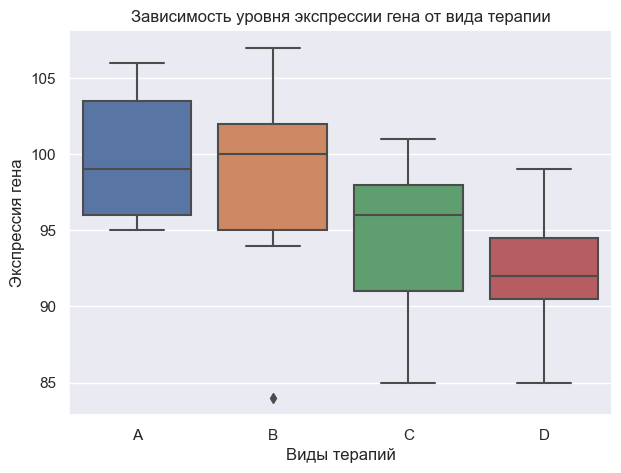

In [11]:
bplot = sns.boxplot(x='Therapy', y='expr', data=gene).set(xlabel='Виды терапий', 
                                                          ylabel='Экспрессия гена', 
                                                          title='Зависимость уровня экспрессии гена от вида терапии')

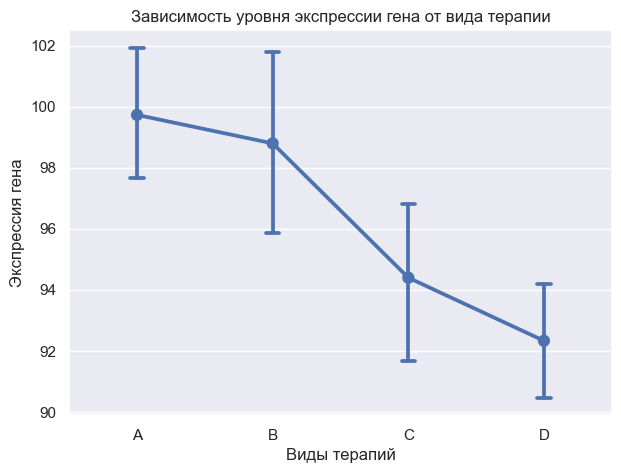

In [12]:
pplot = sns.pointplot(x='Therapy', y='expr', dodge=0.1, capsize=0.1, data=gene)
plt.title('Зависимость уровня экспрессии гена от вида терапии', fontsize=12)
plt.xlabel('Виды терапий', fontsize=12)
plt.ylabel('Экспрессия гена', fontsize=12)
plt.show()

In [13]:
one_way_anova(gene, 'Therapy', 'expr')

,Sum of Squares,Degrees of Freedom,Mean Square,F ratio,p-value
Sum of Squares Factor (Therapy),560.72,3,186.91,8.04,0.0002
Sum of Squares Within,1302.27,56,23.25,NaN,NaN
Sum of Squares Total,1862.98,59,NaN,NaN,NaN


Удалось выявить статистически значимую взаимосвязь между:                
    1) Типом терапии с показателем уровня экспрессии гена F(3, 56) = 8.04, p < 0.05

# 3.1
Датафрейм - Атеросклероз (два фактора)

In [14]:
url = 'https://stepik.org/media/attachments/lesson/9250/atherosclerosis.csv'
athero = pd.read_csv(url)
athero = athero.astype({'age':str})  # необходимо для подстановки уникальных значений в loc
athero.head(5)

,expr,age,dose
0,107.351478,1,D1
1,104.504438,1,D1
2,103.435134,1,D1
3,109.572882,1,D1
4,114.993803,1,D1


In [15]:
mean_table(athero, 'age', 'dose', 'expr')

,D1,D2,Average
1,104.76,105.55,105.15
2,101.00,102.27,101.64
Average,102.88,103.91,103.40


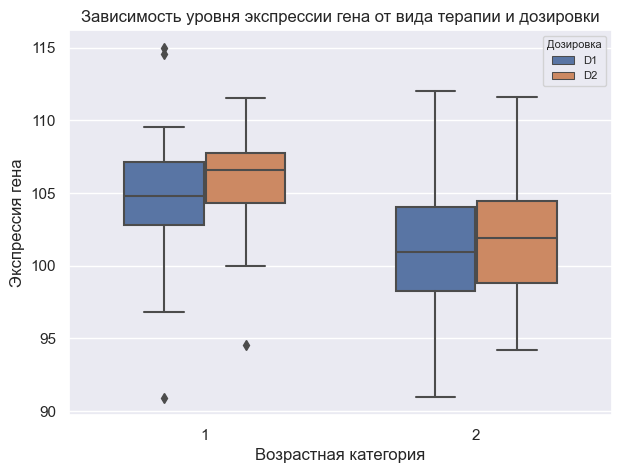

In [16]:
bplot = (sns.boxplot(x='age', y='expr', hue='dose', width=0.6, data=athero)
         .set(xlabel='Возрастная категория', 
              ylabel='Экспрессия гена', 
              title='Зависимость уровня экспрессии гена от вида терапии и дозировки'))
plt.legend(title='Дозировка', title_fontsize=8, fontsize=8)
plt.show()

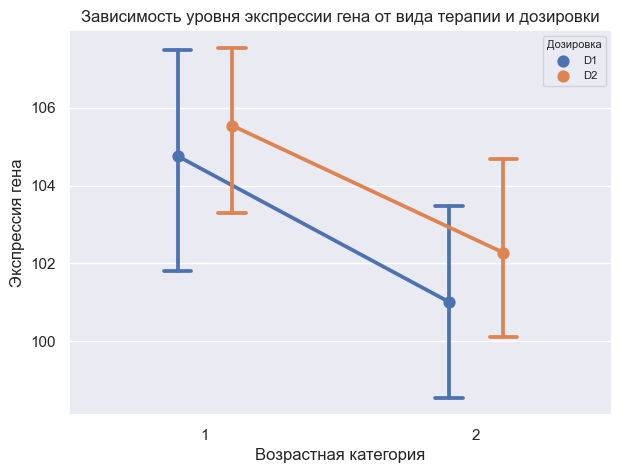

In [17]:
pplot = sns.pointplot(x='age', y='expr', hue='dose', dodge=0.2, capsize=0.1, data=athero)
plt.title('Зависимость уровня экспрессии гена от вида терапии и дозировки', fontsize=12)
plt.xlabel('Возрастная категория', fontsize=12)
plt.ylabel('Экспрессия гена', fontsize=12)
plt.legend(title='Дозировка', title_fontsize=8, fontsize=8)
plt.show()

In [18]:
two_way_anova(athero, 'age', 'dose', 'expr')

,Sum of Squares,Degrees of Freedom,Mean Square,F ratio,p-value
Sum of Squares 1st Factor (age),197.45,1,197.45,7.45,0.0083
Sum of Squares 2nd Factor (dose),16.91,1,16.91,0.64,0.4276
Sum of Squares Both Factors,0.93,1,0.93,0.03,0.8523
Sum of Squares Within (Error),1590.26,60,26.50,NaN,NaN
Sum of Squares Total,1805.55,63,NaN,NaN,NaN


Удалось выявить статистически значимую взаимосвязь между:           
    1) Возрастной категорией с показателем уровня экспрессии гена F(1, 60) = 7.45, p < 0.05
    
Не удалось выявить статистически значимую взаимосвязь между:         
    1) Уровнем дозировки с показателем уровня экспрессии гена F(1, 60) = 0.64, p > 0.05          
    2) Взаимным влиянием возрастной категории и уровнем дозировки 
       с показателем уровня экспрессии гена F(1, 60) = 0.03, p > 0.05

# 3.2
Дата фрейм - инъекции кальция в кровь птиц

In [19]:
url = 'https://stepik.org/media/attachments/lesson/9250/birds.csv'
birds = pd.read_csv(url)
birds = birds.astype({'hormone':str, 'sex':str})
birds.head(5)

,var4,hormone,sex
0,17.859039,1,1
1,20.842343,1,1
2,19.318099,1,1
3,20.064451,1,1
4,17.620316,1,1


In [20]:
mean_table(birds, 'sex', 'hormone', 'var4')

,1,0,Average
1,19.74,17.61,18.68
0,17.29,19.89,18.59
Average,18.52,18.75,18.63


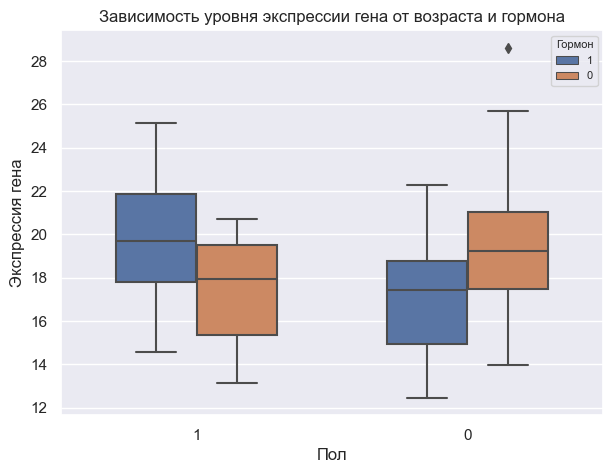

In [21]:
bplot = (sns.boxplot(x='sex', y='var4', hue='hormone', width=0.6, data=birds)
         .set(xlabel='Пол', 
              ylabel='Экспрессия гена', 
              title='Зависимость уровня экспрессии гена от возраста и гормона'))
plt.legend(title='Гормон', title_fontsize=8, fontsize=8)
plt.show()

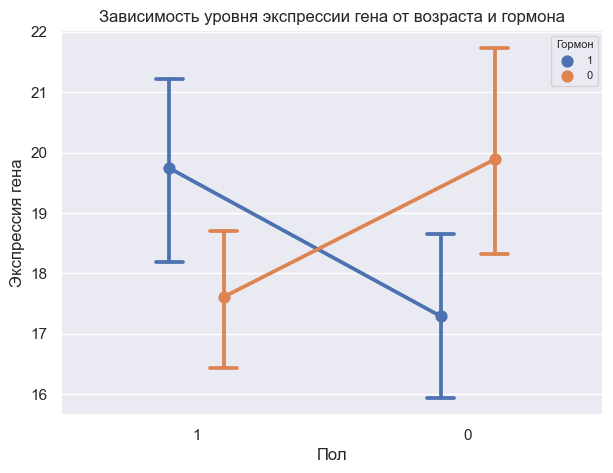

In [22]:
pplot = sns.pointplot(x='sex', y='var4', hue='hormone', dodge=0.2, capsize=0.1, data=birds)
plt.title('Зависимость уровня экспрессии гена от возраста и гормона', fontsize=12)
plt.xlabel('Пол', fontsize=12)
plt.ylabel('Экспрессия гена', fontsize=12)
plt.legend(title='Гормон', title_fontsize=8, fontsize=8)
plt.show()

In [23]:
two_way_anova(birds, 'sex', 'hormone', 'var4')

,Sum of Squares,Degrees of Freedom,Mean Square,F ratio,p-value
Sum of Squares 1st Factor (sex),0.12,1,0.12,0.01,0.9123
Sum of Squares 2nd Factor (hormone),0.85,1,0.85,0.09,0.7697
Sum of Squares Both Factors,89.48,1,89.48,9.14,0.0037
Sum of Squares Within (Error),587.65,60,9.79,NaN,NaN
Sum of Squares Total,678.10,63,NaN,NaN,NaN


Удалось выявить статистически значимую взаимосвязь между:            
    1) Взаимным влиянием пола и гормона с показателем уровня экспрессии гена F(1, 60) = 9.14, p < 0.05
    
Не удалось выявить статистически значимую взаимосвязь между:                
    1) Полом с показателем уровня экспрессии гена F(1, 60) = 0.01, p > 0.05      
    2) Гормоном с показателем уровня экспрессии гена F(1, 60) = 0.09, p > 0.05